In [53]:
### Import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from scipy.optimize import fsolve


font = {'size'   : 8}
plt.rc('font', **font)

## simulation constants
nu = 2e-6
k=0.41
f0=1.37e-4
T=2*np.pi/f0
alpha = 3.8e-5
beta = 7.8e-4
Pr = 14
Sc = 1500
kt=nu/Pr
ks=nu/Sc
L = 3.35e5
cp = 4.184e3 
rhoi = 917
rhow=1030

## Other
syr = 60*60*24*365
sH = 60*60

## Solve for parameterised melt rate - three equations using Jenkins 2010 transfer coefficients
+ $mLc_p = \Gamma_T C_d^{0.5} rms(U)(T-T_b)$

In [ ]:
### J10 melt rate using rms(U)
GT=0.011
GS=4.0e-4
Sinf =34.5
Ca = cp*rhow/(rhoi*L)
Cb = rhow/rhoi
l1 = 0.057
l2 = -0.311

def equations(p):
    Tb, Sb, m = p
    return (Ca*GT*us*(Tml-Tb)- m ,
            (Sml-Sb)*Cb*GS*us/Sb - m,
            -Sb*l1+l2-Tb)


In [103]:
# ### Load data - tidal melting experiments
headstr = '../Data'
tailstr = ['/Stokes-Ekman/','/Stokes/']

## simulation parameters
A0 = [0.028, 0.028]
omega = 1.41e-4
T = 2*np.pi/omega
nT_end = [6,6] # length of sim in tidal periods
tnew = np.linspace(4.9, 6.1, 100)*T

# ###
melt_arr = np.empty([len(A0),len(tnew)])
melt_arr[:,:] = np.nan

for ii in [0,1]: #range(2): 
    fname = '%sISOBL_model_output.nc'% (headstr + tailstr[ii])
    tmp = xr.open_dataset(fname)
    ds = tmp.sel(t=slice(4.9*T, 6.1*T)).interp(t = tnew)
        
    ## heat transfer coefficient: GammaT = kappaT * dT/dz|_b/(DeltaT * u^*)
    DeltaT = ds.Temp.sel(y=0.3, method = 'nearest')-ds.Temp.isel(y=0) 
    DeltaS = ds.Sal.sel(y=0.3, method = 'nearest')-ds.Sal.isel(y=0) 
    dTdz = ds.Temp.differentiate("y").isel(y=0)
    dSdz = ds.Sal.differentiate("y").isel(y=0)
    ustar = (nu*((ds.U.differentiate("y").isel(y=0))**2+(ds.W.differentiate("y").isel(y=0))**2)**0.5)**0.5
    gammaT = kt*dTdz/(ustar*DeltaT)
    gammaS = ks*dSdz/(ustar*DeltaS)
    
    V = -(cp/L)*(nu/Pr)*(1/0.92)*dTdz*syr
    melt_arr[ii,:] = -V
    
    ## solve also for param melt rates
    U_inf = ds.U.sel(y=6, method = 'nearest')
    RMS_U = np.nanmean((U_inf.sel(t=slice(5*T, 6*T)))**2)**0.5
    us = 0.0098**0.5*RMS_U
    Tml = np.nanmean(ds.Temp.sel(y=0.5, method = 'nearest'))
    Sml = np.nanmean(ds.Sal.sel(y=0.5, method = 'nearest'))
    
    ## param meltrate, Cd=0.0098
    us = 0.0098**0.5*RMS_U
    Tb, Sb, m =  fsolve(equations, (Tml, Sml, -0.001/syr))
    print(Tb, Sb, m*syr*100)
    
    ## param meltrate, Cd=0.0025
    us = 0.0025**0.5*RMS_U
    Tb, Sb, m =  fsolve(equations, (Tml, Sml, -0.001/syr))
    print(Tb, Sb, m*syr*100)
    

    


-2.2767831238252043 34.48742322500358 1.0277874992296923
-2.2767831238252043 34.48742322500358 0.3937255127609791
-2.276790330545511 34.487549658693176 1.015484294308953
-2.276790330545511 34.487549658693176 0.46571490048369624


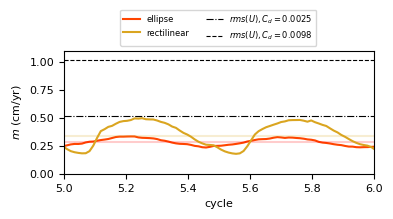

In [127]:
fig, ax1 = plt.subplots()
fig.set_size_inches(4, 1.6)

ax1.plot(ds.t/T,melt_arr[0,:]*100,linewidth=1.5,color='orangered',linestyle='-', label='ellipse')
ax1.axhline(y=np.nanmean(melt_arr[0,:])*100, color='r', linestyle='-', linewidth = 1.5, alpha = 0.2)
ax1.plot(ds.t/T,melt_arr[1,:]*100,linewidth=1.5,color='goldenrod',label='rectilinear',linestyle='-')
ax1.axhline(y=np.nanmean(melt_arr[1,:])*100, color='goldenrod', linestyle='-', linewidth = 1.5, alpha = 0.2)
ax1.axhline(0.513, color='k', linestyle='-.', linewidth = 0.8, label = r'$rms(U), C_d=0.0025$')
ax1.axhline(1.015, color='k', linestyle='--', linewidth = 0.8, label = r'$rms(U), C_d=0.0098$')
ax1.set(ylim = [0, 1.1], xlim = [5, 6],ylabel = r'$m$ (cm/yr)', xlabel = r'cycle')
ax1.legend(fontsize = 6,  ncol = 2, loc=(0.18, 1.04)) 